In [1]:
# vvod = pd.read_csv('data/ввод_в_оборот.csv')
# move = pd.read_csv('data/перемещение_товаров.csv')
# sales = pd.read_csv(
#     'data/выход_товаров.csv',
#     dtype={'price': np.uint32, 'cnt': np.uint32},
#     parse_dates=['dt']
# )

# vvod.to_parquet('data/vvod.parquet')
# move.to_parquet('data/move.parquet')
# sales.to_parquet('data/sales.parquet')

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

vvod = pd.read_parquet('data/vvod.parquet')
move = pd.read_parquet('data/move.parquet')
sales = pd.read_parquet('data/sales.parquet')

In [3]:
production = pd.read_csv('data/Справочник продукции.csv')
tochki = pd.read_csv('data/Справочник торговых точек.csv')
participants = pd.read_csv('data/Справочник участников оборота товаров.csv')

In [4]:
label_enc_d = {}

label_enc_d['id_sp'] = LabelEncoder().fit(tochki.id_sp_.unique().tolist()+sales.id_sp_.unique().tolist())
tochki['id_sp_'] = label_enc_d['id_sp'].transform(tochki.id_sp_).astype(np.uint16)
sales['id_sp_'] = label_enc_d['id_sp'].transform(sales.id_sp_).astype(np.uint16)

label_enc_d['inn'] = LabelEncoder().fit(tochki.inn.unique().tolist()+participants.inn.unique().tolist()+sales.inn.unique().tolist()+\
                                        sales.prid.unique().tolist()+vvod.inn.unique().tolist()+move.receiver_inn.unique().tolist()+\
                                        move.sender_inn.unique().tolist()+move.prid.unique().tolist()+production.inn.unique().tolist())
participants['inn'] = label_enc_d['inn'].transform(participants.inn).astype(np.uint16)
tochki['inn'] = label_enc_d['inn'].transform(tochki.inn).astype(np.uint16)
sales['inn'] = label_enc_d['inn'].transform(sales.inn).astype(np.uint16)
sales['prid'] = label_enc_d['inn'].transform(sales.prid).astype(np.uint16)
vvod['inn'] = label_enc_d['inn'].transform(vvod.inn).astype(np.uint16)
move['prid'] = label_enc_d['inn'].transform(move.prid).astype(np.uint16)
move['sender_inn'] = label_enc_d['inn'].transform(move.sender_inn).astype(np.uint16)
move['receiver_inn'] = label_enc_d['inn'].transform(move.receiver_inn).astype(np.uint16)
vvod['prid'] = label_enc_d['inn'].transform(vvod.prid).astype(np.uint16)
production['inn'] = label_enc_d['inn'].transform(production.inn).astype(np.uint16)

label_enc_d['gtin'] = LabelEncoder().fit(vvod.gtin.unique().tolist()+sales.gtin.unique().tolist()+\
                                         move.gtin.unique().tolist()+production.gtin.unique().tolist())
sales['gtin'] = label_enc_d['gtin'].transform(sales.gtin)
vvod['gtin'] = label_enc_d['gtin'].transform(vvod.gtin).astype(np.uint32)
move['gtin'] = label_enc_d['gtin'].transform(move.gtin).astype(np.uint32)
production['gtin'] = label_enc_d['gtin'].transform(production.gtin).astype(np.uint32)

label_enc_d['product_short_name'] = LabelEncoder().fit(production.product_short_name.unique().tolist())
production['product_short_name'] = label_enc_d['product_short_name'].transform(production.product_short_name)

label_enc_d['product_name'] = LabelEncoder().fit(production.product_name.unique().tolist())
production['product_name'] = label_enc_d['product_name'].transform(production.product_name)

label_enc_d['tnved'] = LabelEncoder().fit(production.tnved.unique().tolist())
production['tnved'] = label_enc_d['tnved'].transform(production.tnved)

label_enc_d['tnved10'] = LabelEncoder().fit(production.tnved10.unique().tolist())
production['tnved10'] = label_enc_d['tnved10'].transform(production.tnved10)

label_enc_d['brand'] = LabelEncoder().fit(production.brand.unique().tolist())
production['brand'] = label_enc_d['brand'].transform(production.brand)

sales['month'] = sales.dt.dt.month.astype(np.int8)
sales['year'] = sales.dt.dt.year.astype(np.int16)
sales['num_month'] = (sales.year - 2021) * 12 + sales.month


sales = sales.merge(tochki[['id_sp_', 'region_code']], how='left', on='id_sp_')
sales = sales.merge(production[['gtin', 'product_short_name', 'product_name']], how='left', on='gtin')
sales['region_code'] = sales['region_code'].fillna(-1).astype(np.int8)
sales['product_name'] = sales['product_name'].fillna(-1).astype(np.int32)
sales['product_short_name'] = sales['product_short_name'].fillna(-1).astype(np.int16)

In [5]:
a = sales.groupby('product_short_name')['cnt'].sum()
a = a[a > 2000].index
sales = sales[sales.product_short_name.isin(a)]

In [52]:
MAIN_D = {}

for region in tqdm(sales.region_code.unique()):
    cur_sales = sales[(sales.product_name!=-1)&(sales.region_code==region)&(sales.type_operation=='Продажа конечному потребителю в точке продаж')][['num_month', 'product_name', 'product_short_name', 'price', 'cnt']]

    cur_sales['comb'] = cur_sales['num_month'].astype('str') + '__' + cur_sales['product_name'].astype('str') + '__' + cur_sales['product_short_name'].astype('str')

    cnt, price, comb = cur_sales.cnt.tolist(), cur_sales.price.tolist(), cur_sales.comb.tolist()
    cur_d = {x: [0,0] for x in cur_sales.comb.unique()}
    for x, cur_comb in enumerate(comb):
        cur_d[cur_comb][0] += price[x] * cnt[x]
        cur_d[cur_comb][1] += cnt[x]

    month, name, short_name = [], [], []
    w_average, cnt = [], []
    for x, y in cur_d.items():
        month.append(int(x.split('__')[0]))
        name.append(x.split('__')[1])
        short_name.append(x.split('__')[2])
        w_average.append(y[0]/y[1])
        cnt.append(y[1])

    cur_sales = pd.DataFrame({
        'month': month,
        'product_name': name,
        'product_short_name': short_name,
        'price': w_average,
        'cnt': cnt
    })

    product_info = pd.pivot_table(
        cur_sales,
        columns='product_short_name',
        index=['month', 'product_name'],
        aggfunc='median',
        values='price'
    )# .dropna(axis=1)

    month_change = (product_info.unstack().dropna(axis=1).pct_change()+1).dropna(axis=0)
    
    MAIN_D[region] = {}
    for col1, col2 in month_change.columns:
        if int(col1) not in MAIN_D[region]:
            MAIN_D[region][int(col1)] = []
        MAIN_D[region][int(col1)].append(month_change[(col1, col2)].values)

 13%|█▎        | 11/86 [02:39<18:07, 14.50s/it]


KeyboardInterrupt: 

In [73]:
NEW_D = {}
for reg, it in MAIN_D.items():
    d = {}
    for key, i in it.items():
        d[key] = np.array(i).mean(axis=0)
    NEW_D[reg] = d

Text(0.5, 0, 'Месяц')

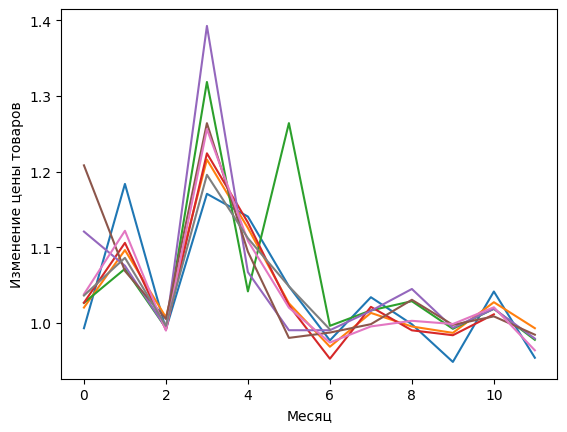

In [81]:
for reg, it in NEW_D.items():
    if len(it[109]) and max(it[109]) < 2:
        plt.plot(it[109])

plt.ylabel('Изменение цены товаров')
plt.xlabel('Месяц') # 12-декабрь 2021;    13-январь 2022

In [8]:
month_change

product_short_name       109                                           
product_name          100704    100765    100861    101557    101642   
month                                                                  
12                  0.980059  1.000000  0.851583  1.297304  0.844721  \
13                  1.052906  1.019633  1.726382  1.001963  1.237704   
14                  0.939913  1.028883  0.666230  1.071659  1.035752   
15                  1.294058  1.191668  1.150022  1.143229  1.013293   
16                  1.051100  1.300698  0.856033  1.079541  1.342837   
17                  1.022365  0.967741  1.341663  0.968577  0.846425   
18                  0.940189  1.038626  0.781993  0.923843  1.134961   
19                  1.003909  0.987511  1.203820  0.903035  1.070572   
20                  1.043455  1.012647  0.922454  0.952636  0.885485   
21                  0.913286  1.000000  1.061583  1.034445  1.022303   
22                  1.010635  0.821242  1.027482  0.938329  0.931877   
23                  0.940221  0.966926  0.778273  0.837683  0.899519   

product_short_name                                                    ...   
product_name          102192    102847    104349    104778    105150  ...   
month                                                                 ...   
12                  1.053431  1.295245  0.814738  0.878924  0.977815  ...  \
13                  1.196977  1.029415  1.552061  1.287957  1.021357  ...   
14                  0.796262  1.050007  0.811346  0.919851  0.961651  ...   
15                  1.009903  1.178115  0.994397  1.274512  1.032216  ...   
16                  1.083096  1.146715  1.146570  0.972405  1.005781  ...   
17                  1.634533  0.933350  1.398934  1.261997  1.268248  ...   
18                  0.496565  1.071410  0.802852  0.976268  0.951130  ...   
19                  0.654567  1.000000  0.997832  1.057426  1.029595  ...   
20                  1.458487  0.983578  1.048000  0.914676  0.992691  ...   
21                  0.759888  0.842404  1.132679  1.083926  1.002315  ...   
22                  1.000000  0.929170  0.939256  0.988585  1.004712  ...   
23                  2.156444  1.273301  0.889743  0.934059  0.993786  ...   

product_short_name        88                  93                       
product_name           97438     98190    106818    125761    135484   
month                                                                  
12                  1.046102  1.390956  1.289997  0.965997  0.857960  \
13                  1.394111  0.997707  1.007753  1.021232  1.219702   
14                  1.034923  1.080902  1.076929  1.050335  1.126123   
15                  0.734260  1.098189  1.178021  1.500000  1.100692   
16                  1.331280  1.023977  1.038104  1.040000  0.992440   
17                  1.080498  1.115145  0.938927  1.013967  1.092031   
18                  0.942801  0.899996  1.046512  1.229852  1.133155   
19                  0.849800  0.744518  0.835235  0.740936  0.993616   
20                  1.136681  1.006635  0.967742  1.349645  0.989517   
21                  0.888672  1.080904  0.791812  0.794997  0.912029   
22                  1.254549  0.924683  1.021381  0.885337  1.036058   
23                  0.892686  0.651778  1.144593  0.860401  0.970524   

product_short_name                                                    
product_name          146406    168936    221032     70674     97457  
month                                                                 
12                  0.818313  0.931023  1.059357  1.367111  0.860885  
13                  1.240300  1.155838  1.024514  1.041537  1.231117  
14                  1.212081  0.992053  1.000000  1.053455  1.125322  
15                  1.033763  1.117079  1.109014  1.122660  1.189578  
16                  1.169909  1.057820  1.054964  1.030961  1.023133  
17                  1.125486  1.342833  1.003959  0.973845  1.126968  
18                  0.883139  0.999096  0.9

In [25]:
a = production[['product_name', 'product_short_name']].drop_duplicates()
change_d = {}
for product_name in a.product_name.unique():
    change_d[product_name] = a[a.product_name==product_name]['product_short_name'].tolist()

In [29]:
change_d

{118124: [88],
 115936: [88, 93, 70, 113, 56, 61, 99],
 169961: [88],
 263765: [109],
 132356: [88, 93, 109],
 184214: [109],
 197130: [109],
 165535: [109],
 163789: [88, 109, 93, 78, 47, 22],
 137545: [88],
 91710: [88, 109],
 97143: [22],
 261072: [88],
 207529: [109, 88, 93, 22, 78, 105, 72, 83, 31],
 83696: [109],
 141108: [88],
 208114: [88],
 74028: [88],
 223375: [88],
 1448: [88],
 157295: [88],
 155417: [88],
 190664: [109],
 287485: [109],
 87288: [109],
 13085: [109],
 194620: [109],
 31933: [109],
 123579: [109],
 42853: [109],
 279401: [109],
 20426: [109],
 287178: [88],
 92294: [109],
 55426: [109],
 285102: [88],
 236887: [109],
 194533: [88],
 104049: [88],
 73415: [88],
 84338: [22],
 180883: [22],
 21521: [22],
 81681: [22],
 68420: [88],
 98142: [22],
 37699: [22],
 60915: [22],
 95688: [88],
 42424: [88],
 52528: [88],
 27470: [88],
 22248: [88],
 5147: [88],
 12138: [88],
 102192: [109],
 229607: [109],
 205660: [109],
 287267: [109],
 264571: [115],
 131574: [11

In [11]:
a = '100704	100765	100861	101142	101264	101396	101557	101642	101713	97438	97457	97925	98060	98190	98228	98246	99332	99843	99911'.split()

In [ ]:
MAIN_D = {}
MAIN_D[region] = {}



In [14]:
months = month_change.index
products = month_change.columns
values = month_change.values

tnved10
217    318266
79      68270
149      4120
131       590
193       451
        ...  
47          1
199         1
10          1
37          1
113         1
Name: count, Length: 220, dtype: int64